<a href="https://colab.research.google.com/github/evan-person/variousCodingCoursework/blob/main/computerVision/IRsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IR segmentation using OpenCV and Python
Evan Lucas

Load and wrangle data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp ./gdrive/MyDrive/'IR segmentation.zip' ./

In [ ]:
!unzip -q 'IR segmentation.zip' -d ./data

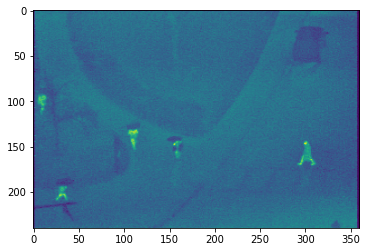

In [ ]:
#plot a picture for giggles
import matplotlib.pyplot as plt

img = plt.imread('./data/00001/img_00001.bmp')
plt.imshow(img)

In [ ]:
import os

folderList = os.listdir('./data')

In [ ]:
import numpy as np
import cv2

#train on 20%, test on 80%
counter = 0
histStack = np.zeros((256,1))
for ii in range(2):
  fileList = os.listdir(os.path.join('./data/',folderList[ii]))
  for jj in fileList:
    fileName = os.path.join('./data/',folderList[ii],jj)
    splitFile = os.path.splitext(jj)
    if splitFile[1] == '.bmp':
      img = plt.imread(fileName)
      histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
      counter +=1
      histStack += histr

#normalize
histStack = histStack/counter

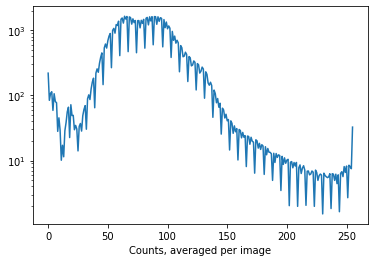

In [ ]:


plt.plot(histStack)
plt.yscale('log')
plt.xlabel('Pixel value')
plt.xlabel('Counts, averaged per image')
plt.show()

just gonna make a guess and start with a threshold of 125 for now - seems like a good inflection point. 

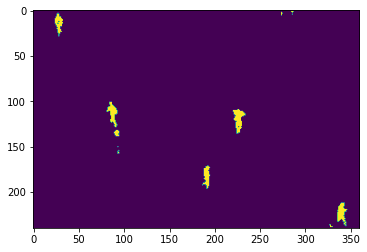

In [ ]:
ret, th1 = cv2.threshold(img,125,255,cv2.THRESH_BINARY)

plt.imshow(th1)

Looks pretty good, let's try to be more aggressive

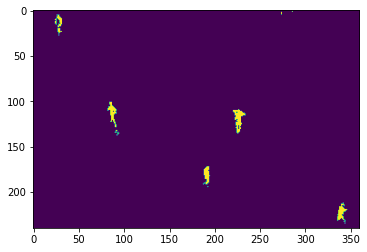

In [ ]:
ret, th1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY)

plt.imshow(th1)

let's try dilating and eroding to remove false blobs

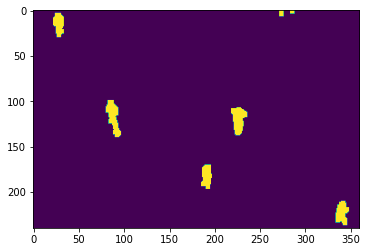

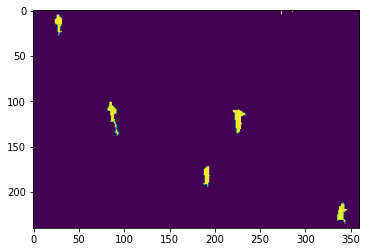

In [ ]:
kernel1 = np.ones((5,5),np.uint8)


dilated = cv2.dilate(th1,kernel1,iterations = 1)
plt.imshow(dilated)
plt.show()


kernel2 = np.ones((5,5),np.uint8)

eroded = cv2.erode(dilated,kernel2, iterations = 1)

plt.imshow(eroded)
plt.show()







Let's find the center point of each blob and plot a circle there to prove that it's working

7
5


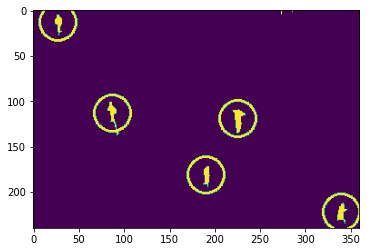

In [ ]:

from matplotlib.patches import Circle
#fig,ax = plt.subplots(1)
#ax.imshow(eroded)
contours, hierarchy = cv2.findContours(eroded,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
counter = 0

xs = np.empty(shape = [0,1])
ys = np.empty(shape = [0,1])
for c in contours:

  M = cv2.moments(c)
  #it was finding some zero area points, so this removes those
  if M["m00"] != 0:
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    counter += 1
    xs = np.append(xs,cX)
    ys = np.append(ys,cY)
  #circle = Circle((cX,cY),20)
  #ax.add_patch(circle)
  outputImg = cv2.circle(eroded,(cX,cY),20,(255,255,0),2)
print(counter)


plt.imshow(outputImg)


In [ ]:
def pointInRect(point,rect):
    x1, y1, x2, y2 = rect

    x, y = point
    if (x1 < x and x < x2):
        if (y1 < y and y < y2):
            return True
    return False


test code for checking each point

In [ ]:
import linecache
targetLocations = os.path.join('./data/',folderList[ii],'groundTruth.txt')



line = linecache.getline(targetLocations,int(jj[-6:-4])+4)
targetCoords = line.split('(')
nTargets = int(targetCoords[0].split()[-1])

for n in range(nTargets):
  indivCoords = targetCoords[1+n].replace(')','').split()
  indivCoordsInt = [int(i) for i in indivCoords]

  print(pointInRect([cX,cY],indivCoordsInt))
  print([cX,cY])
  print(indivCoordsInt)

False
[27, 13]
[216, 109, 239, 139]
False
[27, 13]
[180, 172, 203, 202]
False
[27, 13]
[329, 210, 352, 240]
False
[27, 13]
[76, 100, 100, 132]
True
[27, 13]
[19, 3, 40, 31]


We can be fancy and use an adaptive threshold for giggles, although that ends up acting like an edge detector

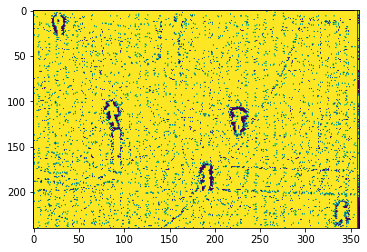

In [ ]:
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,13)
plt.imshow(th2)

We could also try to use Otsu's Binarization that attempts to find a bimodal distribution. Apparently smoothing first helps improve the results, which it looks like it really does!!

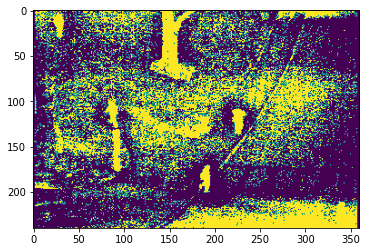

Otsu's optimal threshold is 66.0


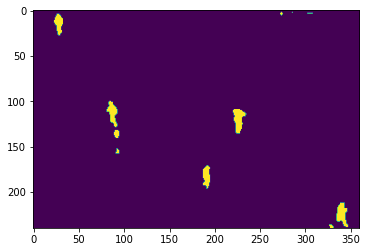

optimal threshold after blurring is 108.0


In [ ]:
ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th3)
plt.show()
print("Otsu's optimal threshold is",ret3)

img2 = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th3)
plt.show()
print('optimal threshold after blurring is',ret3)

let's tweak that a little bit to see fi we can get rid of the extra blobs

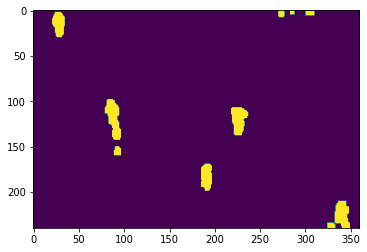

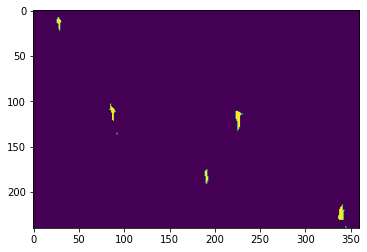

In [ ]:
kernel1 = np.ones((5,5),np.uint8)


dilated = cv2.dilate(th3,kernel1,iterations = 1)
plt.imshow(dilated)
plt.show()


kernel2 = np.ones((9,9),np.uint8)

eroded = cv2.erode(dilated,kernel2, iterations = 1)

plt.imshow(eroded)
plt.show()



Let's create a function to do the two different workflows


In [ ]:
def irSegPipeline1(img,thresh):
  ret, th1 = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY)
  kernel1 = np.ones((5,5),np.uint8)
  dilated = cv2.dilate(th1,kernel1,iterations = 1)
  kernel2 = np.ones((5,5),np.uint8)
  eroded = cv2.erode(dilated,kernel2, iterations = 1)


  contours, hierarchy = cv2.findContours(eroded,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


  xs = np.empty(shape = [0,1])
  ys = np.empty(shape = [0,1])
  for c in contours:

    M = cv2.moments(c)
  #it was finding some zero area points, so this removes those
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      
      xs = np.append(xs,cX)
      ys = np.append(ys,cY)
  return xs, ys

In [ ]:
def irSegPipeline2(img):
  img2 = cv2.GaussianBlur(img,(5,5),0)
  ret3,th3 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  kernel1 = np.ones((5,5),np.uint8)


  dilated = cv2.dilate(th3,kernel1,iterations = 1)



  kernel2 = np.ones((9,9),np.uint8)

  eroded = cv2.erode(dilated,kernel2, iterations = 1)




  contours, hierarchy = cv2.findContours(eroded,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


  xs = np.empty(shape = [0,1])
  ys = np.empty(shape = [0,1])
  for c in contours:

    M = cv2.moments(c)
  #it was finding some zero area points, so this removes those
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      
      xs = np.append(xs,cX)
      ys = np.append(ys,cY)
  return xs, ys

List of methods to try:

Manually thresholded, dilated, eroded, and blob detected

Otsu to blob detection

Now I gotta write a scoring system to check the text files for targets

Let's try Otsu's method first

In [ ]:
#lets test on the other 80% of the data
nDatasets = 10
tp = np.zeros((nDatasets,1))
fp = np.zeros((nDatasets,1))
targetCount = np.zeros((nDatasets,1))
for ii in range(nDatasets):
  fileList = os.listdir(os.path.join('./data/',folderList[ii]))
  fileCount = 0
  
  for jj in fileList:
    fileName = os.path.join('./data/',folderList[ii],jj)
    splitFile = os.path.splitext(jj)
    if splitFile[1] == '.bmp':
      fileCount += 1
      img = plt.imread(fileName)
      xs, ys = irSegPipeline2(img)
      targetLocations = os.path.join('./data/',folderList[ii],'groundTruth.txt')



      line = linecache.getline(targetLocations,int(jj[-6:-4])+4)
      targetCoords = line.split('(')
      nTargets = int(targetCoords[0].split()[-1])
      targetCount[ii,0] += nTargets
      #loop through targets
      placeHolder2 = 0
      for n in range(nTargets):
        indivCoords = targetCoords[1+n].replace(')','').split()
        indivCoordsInt = [int(i) for i in indivCoords]
        #check each identified target
        placeHolder = 0
        for k in range(len(xs)):
          check = pointInRect([xs[k],ys[k]],indivCoordsInt)
          placeHolder += int(check)
          placeHolder2 += int(check)
        if placeHolder >= 1 :
          tp[ii,0] += 1
      fp[ii,0] += len(xs) - placeHolder2
      #print(pointInRect([cX,cY],indivCoordsInt).astype(bool))
  tp[ii,0] = tp[ii,0]/targetCount[ii,0]


In [ ]:
print(np.mean(tp))
print(fp)
print(targetCount)

0.49938253514966535
[[ 281.]
 [ 335.]
 [ 446.]
 [ 274.]
 [ 593.]
 [ 530.]
 [ 316.]
 [ 130.]
 [ 403.]
 [1488.]]
[[101.]
 [ 97.]
 [101.]
 [ 94.]
 [ 97.]
 [100.]
 [ 91.]
 [109.]
 [ 99.]
 [ 95.]]


This does not work well overall


Next up we can test on the other method using a single threshold

In [ ]:

nDatasets = 10
tp = np.zeros((nDatasets,1))
fp = np.zeros((nDatasets,1))
targetCount = np.zeros((nDatasets,1))
for ii in range(nDatasets):
  fileList = os.listdir(os.path.join('./data/',folderList[ii]))
  fileCount = 0
  
  for jj in fileList:
    fileName = os.path.join('./data/',folderList[ii],jj)
    splitFile = os.path.splitext(jj)
    if splitFile[1] == '.bmp':
      fileCount += 1
      img = plt.imread(fileName)
      xs, ys = irSegPipeline1(img,150)
      targetLocations = os.path.join('./data/',folderList[ii],'groundTruth.txt')



      line = linecache.getline(targetLocations,int(jj[-6:-4])+4)
      targetCoords = line.split('(')
      nTargets = int(targetCoords[0].split()[-1])
      targetCount[ii,0] += nTargets
      #loop through targets
      placeHolder2 = 0
      for n in range(nTargets):
        indivCoords = targetCoords[1+n].replace(')','').split()
        indivCoordsInt = [int(i) for i in indivCoords]
        #check each identified target
        placeHolder = 0
        for k in range(len(xs)):
          check = pointInRect([xs[k],ys[k]],indivCoordsInt)
          placeHolder += int(check)
          placeHolder2 += int(check)
        if placeHolder >= 1 :
          tp[ii,0] += 1
      fp[ii,0] += len(xs) - placeHolder2
      #print(pointInRect([cX,cY],indivCoordsInt).astype(bool))
  tp[ii,0] = tp[ii,0]/targetCount[ii,0]


In [ ]:
print(tp)
print(fp)

[[0.97029703]
 [0.98969072]
 [0.65346535]
 [0.87234043]
 [0.98969072]
 [0.95      ]
 [1.        ]
 [0.99082569]
 [1.        ]
 [1.        ]]
[[229.]
 [ 14.]
 [793.]
 [ -2.]
 [101.]
 [121.]
 [  1.]
 [ 96.]
 [ 23.]
 [ 75.]]


There's something buggy in there with the false positives, but I'm happy enough with it

Let's try looping through a range of thresholds and make some curves

In [ ]:
nDatasets = 10
tp = np.zeros((nDatasets,12))
fp = np.zeros((nDatasets,12))
countA = 0
for a in range(100,220,10):

  targetCount = np.zeros((nDatasets,1))
  for ii in range(nDatasets):
    fileList = os.listdir(os.path.join('./data/',folderList[ii]))
    fileCount = 0
  
    for jj in fileList:
      fileName = os.path.join('./data/',folderList[ii],jj)
      splitFile = os.path.splitext(jj)
      if splitFile[1] == '.bmp':
        fileCount += 1
        img = plt.imread(fileName)
        xs, ys = irSegPipeline1(img,a)
        targetLocations = os.path.join('./data/',folderList[ii],'groundTruth.txt')



        line = linecache.getline(targetLocations,int(jj[-6:-4])+4)
        targetCoords = line.split('(')
        nTargets = int(targetCoords[0].split()[-1])
        targetCount[ii,0] += nTargets
      #loop through targets
        placeHolder2 = 0
        for n in range(nTargets):
          indivCoords = targetCoords[1+n].replace(')','').split()
          indivCoordsInt = [int(i) for i in indivCoords]
        #check each identified target
          placeHolder = 0
          for k in range(len(xs)):
            check = pointInRect([xs[k],ys[k]],indivCoordsInt)
            placeHolder += int(check)
            placeHolder2 += int(check)
          if placeHolder >= 1 :
            tp[ii,countA] += 1
        fp[ii,countA] += len(xs) - placeHolder2
      #print(pointInRect([cX,cY],indivCoordsInt).astype(bool))
    tp[ii,countA] = tp[ii,countA]/targetCount[ii,0]
  countA += 1

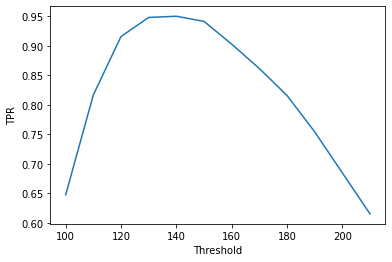

In [ ]:
tpr = np.mean(tp,axis = 0)

a = list(range(100,220,10))
plt.plot(a,tpr)
plt.xlabel('Threshold')
plt.ylabel('TPR')
plt.show()

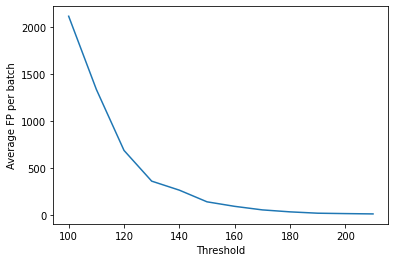

In [ ]:
fpr = np.mean(fp,axis = 0)

a = list(range(100,220,10))
plt.plot(a,fpr)
plt.xlabel('Threshold')
plt.ylabel('Average FP per batch')
plt.show()